In [2]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from timm.models.efficientvit_mit import GELUTanh, ResidualBlock, build_local_block
from evit import EfficientVitLargeStageND, GroupNorm8
from codec import AutoEncoderND
from tft.wavelet import WPT2D, IWPT2D, DWT2DForward, DWT2DInverse
from tft.utils import compand, decompand
dataset = datasets.load_dataset("danjacobellis/LSDIR")

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [7]:
config = SimpleNamespace()
config.F = 16
config.latent_dim = 12;
config.input_channels = 3
config.lightweight_encode = True
config.lightweight_decode = False
config.λ = 1.0e-1
config.ema_decay = 0.999
config.consistency_start = 0.05
config.consistency_loss = 1.0
config.lr_pow = 6
config.progressive_sizes = [16*int(s) for s in np.linspace(2,3.11,36)**3]; print(config.progressive_sizes)
config.batch_size = 48
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.epochs = 36
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False

[128, 128, 128, 144, 144, 160, 160, 160, 176, 176, 192, 192, 208, 224, 224, 240, 240, 256, 256, 272, 288, 288, 304, 320, 336, 336, 352, 368, 384, 384, 400, 416, 432, 448, 464, 480]


In [8]:
model = AutoEncoderND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

61.930908 M parameters


In [9]:
import copy
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update(self, student):
        for ema_p, student_p in zip(self.teacher.parameters(), student.parameters()):
            ema_p.copy_(ema_p * self.decay + student_p * (1 - self.decay))

In [10]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def collate_fn(batch, epoch):
    img_size = get_epoch_size(epoch)
    return torch.cat([
        PILToTensor()(RandomCrop(img_size)(sample['image'])).unsqueeze(0)
        for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []
consistency_losses = []

ema_helper = EMAHelper(model, decay=config.ema_decay)

global_step = 0
model.train()
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        # Main model forward pass (additive noise)
        z = model.encode(x)
        z_noisy = model.quantize(z)  # noisy (training mode)
        x_hat = model.decode(z_noisy)

        # Reconstruction and rate loss
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate = model.quantize.compand(z).std().log2()
        rate_losses.append(rate.item())

        total_loss = mse_loss + config.λ * rate

        # EMA Latent Consistency Loss (only after certain training point)
        if global_step > config.consistency_start * config.total_steps:
            with torch.no_grad():
                z_teacher = ema_helper.teacher.encode(x)
                z_teacher = ema_helper.teacher.quantize.compand(z_teacher).round()
            consistency_loss = torch.nn.functional.mse_loss(
                model.quantize.compand(z), z_teacher
            ).log10()
            consistency_losses.append(consistency_loss.item())
            total_loss += config.consistency_loss * consistency_loss
            pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"Consistency: {consistency_loss:.4f}, LR: {learning_rates[-1]:.2g}")
        else:
            pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"LR: {learning_rates[-1]:.2g}")

        # Backpropagation and optimizer step
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # EMA update step after optimizer step
        ema_helper.update(model)

        global_step += 1

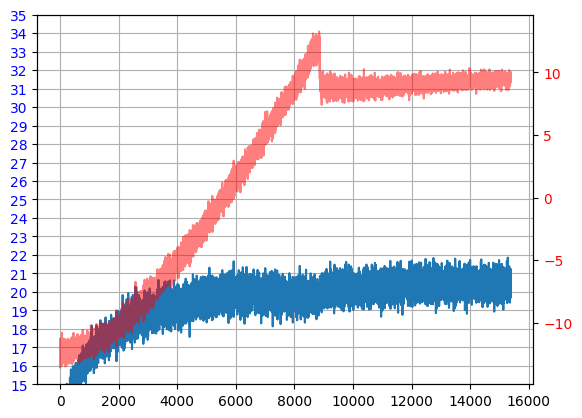

In [12]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

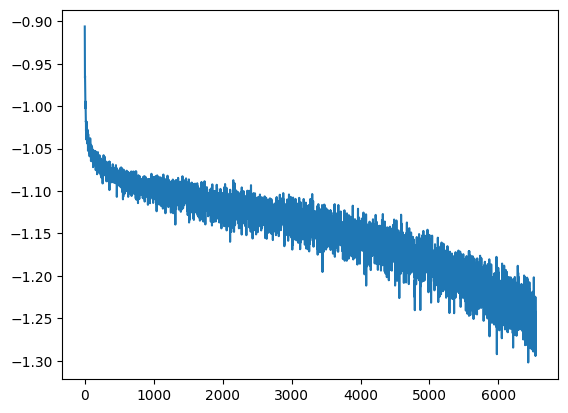

In [13]:
plt.plot(consistency_losses)

In [14]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../hf/dance/LF_rgb_f16c12_v1.0.pth')

In [15]:
from einops import rearrange
def to_bytes(x, n_bits):
    max_value = 2**(n_bits - 1) - 1
    min_value = -max_value - 1
    if x.min() < min_value or x.max() > max_value:
        raise ValueError(f"Tensor values should be in the range [{min_value}, {max_value}].")
    return (x + (max_value + 1)).to(torch.uint8)

def from_bytes(x, n_bits):
    max_value = 2**(n_bits - 1) - 1
    return (x.to(torch.float32) - (max_value + 1))

def concatenate_channels(x, C):
    batch_size, N, h, w = x.shape
    if N % C != 0 or int((N // C)**0.5) ** 2 * C != N:
        raise ValueError(f"Number of channels must satisfy N = {C} * (n^2) for some integer n.")
    
    n = int((N // C)**0.5)
    x = rearrange(x, 'b (c nh nw) h w -> b (nh h) (nw w) c', c=C, nh=n, nw=n)
    return x

def split_channels(x, N, C):
    batch_size, _, H, W = x.shape
    n = int((N // C)**0.5)
    h = H // n
    w = W // n
    
    x = rearrange(x, 'b c (nh h) (nw w) -> b (c nh nw) h w', c=C, nh=n, nw=n)
    return x

def latent_to_pil(latent, n_bits, C):
    latent_bytes = to_bytes(latent, n_bits)
    concatenated_latent = concatenate_channels(latent_bytes, C)
    
    if C == 1:
        mode = 'L'
        concatenated_latent = concatenated_latent.squeeze(-1)
    elif C == 3:
        mode = 'RGB'
    elif C == 4:
        mode = 'CMYK'
    else:
        raise ValueError(
            f"Unsupported number of channels C={C}. Supported values are 1 (L), 3 (RGB), and 4 (CMYK)"
        )
    
    pil_images = []
    for i in range(concatenated_latent.shape[0]):
        pil_image = PIL.Image.fromarray(concatenated_latent[i].numpy(), mode=mode)
        pil_images.append(pil_image)
    
    return pil_images

def pil_to_latent(pil_images, N, n_bits, C):
    tensor_images = [PILToTensor()(img).unsqueeze(0) for img in pil_images]
    tensor_images = torch.cat(tensor_images, dim=0)
    split_latent = split_channels(tensor_images, N, C)
    latent = from_bytes(split_latent, n_bits)
    return latent

1.662 KB
415.884476534296x compression ratio
64.0x dimension reduction
19.041092414855957 dB PSNR


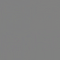

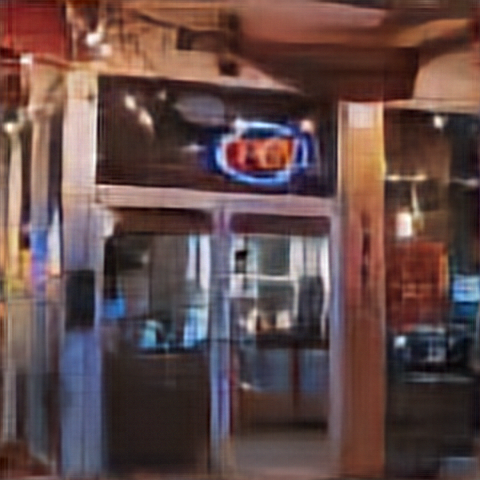

In [16]:
model.eval()
config.img_size=480
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

if True:
    model.eval()
    with torch.no_grad():
        z = model.encode(x)
        latent = model.quantize.compand(z).round()
    webp = latent_to_pil(latent.cpu(),n_bits=8, C=3)
    buff = io.BytesIO()
    webp[0].save(buff, format='WEBP', lossless=True)
    size_bytes = len(buff.getbuffer())
    print(f"{size_bytes/1e3} KB")
    print(f"{orig_dim/size_bytes}x compression ratio")
    print(f"{orig_dim/latent.numel()}x dimension reduction")
    latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
else:
    model.train()
    with torch.no_grad():
        z = model.encode(x)
        latent_decoded = model.quantize(z)

with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1,1)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")
display(webp[0])
ToPILImage()(x_hat[0]/2+0.5)

bpc: 1.3089425762838034, cr: 391.1554328484069


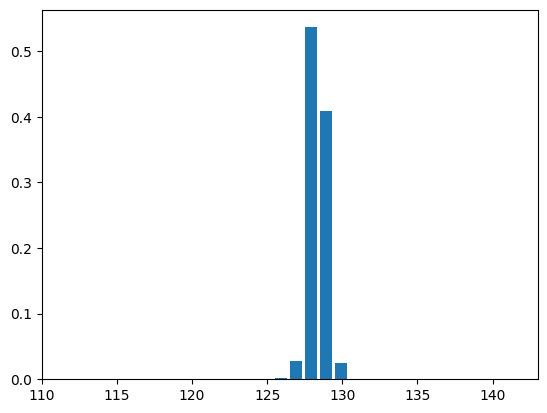

In [17]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([110,143])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")

In [12]:
# img.crop((0,0,config.img_size,config.img_size)).save("test.webp",quality=10)
# webp = PIL.Image.open("test.webp")
# MSE = torch.nn.functional.mse_loss(PILToTensor()(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
# print(f"{-10*MSE.log10()} PSNR")
# !du -sh test.webp
# display(webp)

In [17]:
1/(np.mean(rate_losses[-100:])/np.mean(losses[-100:]))

-3.078665601607304